In [9]:
for align, text in zip('<^>', ['left', 'center', 'right']):
    print('{0:{fill}{align}32}'.format(text, fill=align, align=align))

ValueError: Invalid format specifier

In [8]:
align

'>'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

In [2]:
start_test_date = '2016-01-01'
df_pred = pd.read_pickle('df_predictions.pkl')
df_risk = pd.read_pickle('df_risk.pkl').query("volatility > 1e-3")
df_merge = df_risk.merge(df_pred, on = ['asset_identifier', 'date'], how = 'left')
df_merge.to_pickle('df_merge.pkl')
df_merge.query("date >= @start_test_date", inplace = True)
del df_pred
del df_risk

In [25]:
def sharpe_ratio(pnl):
    print('sharpe ratio: ' + str(pnl.mean() / pnl.std() * 252**0.5))
def sum_pnl(pnl):
    print('PnL: ' + str(pnl.mean() * 252 * 100) + '%')
def vol_pnl(pnl):
    print('Annual volatility: ' + str(pnl.std() * 252**0.5 * 100) + '%')
def cumpute_variance(w, cov_matrix):
    return (w.T @ cov_matrix @ w)

def min_variance(cov_matrix):
    ones = np.ones((len(cov_matrix), 1))
    inv = np.linalg.inv(cov_matrix)
    w = inv @ ones
    w = w/np.abs(w).sum()
    return w

def get_cov_matrix(data):
    rho_times_vol = data.set_index('asset_identifier').eval("rho * volatility")
    variance      = data.set_index('asset_identifier').eval("volatility**2").values

    rho_times_vol = rho_times_vol.values.reshape((-1, 1))
    cov_matrix = rho_times_vol @ rho_times_vol.T
#     cov_matrix = np.zeros((len(data), len(data)))
    for i in range(len(cov_matrix)):
        cov_matrix[i][i] = variance[i]
    return cov_matrix

In [26]:
#equal weight
pnl_ew = df_merge.groupby('date')['target'].mean()
sharpe_ratio(pnl_ew)
sum_pnl(pnl_ew)
vol_pnl(pnl_ew)

sharpe ratio: 0.8434241478564751
PnL: 17.882780777290463%
Annual volatility: 21.2025947205487%


In [84]:
#top 5
df_merge.loc[:, 'rank_pred'] = df_merge.groupby('date')['yhat'].rank(ascending = False, pct = False)
pnl_top_10 = df_merge.query("rank_pred < 5").groupby('date')['target'].mean()
sharpe_ratio(pnl_top_10)
sum_pnl(pnl_top_10)
vol_pnl(pnl_top_10)

sharpe ratio: 1.0678776045382985
PnL: 24.06327452044934%
Annual volatility: 22.533739444936586%


In [9]:
import scipy.optimize as opt

In [10]:
import math

In [31]:
def clip(value, down, up):
    if value > up:
        return up
    elif value < down:
        return down
    else:
        return value

In [52]:
#min variance
target_vol = 0.5e-2
list_pnl = []
for date, data in df_merge.groupby('date'):
    cov_matrix = get_cov_matrix(data)
#     w = min_variance(cov_matrix)
    w = np.ones(len(cov_matrix)).reshape(-1, 1)
    vol = cumpute_variance(w, cov_matrix).item()**0.5
    print(vol)
    w = w * clip(target_vol/vol, 0, 1000)
#     print(cumpute_variance(w, cov_matrix).item()**0.5)
    pnl = w.reshape(-1) * data['target'].values
    pnl = pnl.sum()
    list_pnl.append(pnl)

0.0928913192450554
0.09768270508800073
0.09178345293335136
0.09195817896653044
0.10218581444646778
0.10176742167115366
0.10237860805833987
0.09960800169210172
0.1053186180059434
0.10860802658621647
0.11192511872925756
0.11182161242243921
0.10839100555637038
0.11045073438838202
0.12097555274027469
0.11868051237012857
0.1232076687673099
0.1262085596884489
0.14179802379145034
0.14800676669760124
0.14741627140995447
0.1473882260088408
0.1484033967182685
0.14870976908494615
0.15162481513331863
0.15234416209315543
0.15233521872403077
0.15225366970414525
0.14751635752219594
0.1446567622534621
0.14231353276485045
0.14432657115544217
0.14344090987571528
0.14290038338496278
0.13984202559634895
0.14050541793325066
0.1376833211843894
0.13244168645511004
0.11315318706261196
0.10058950433603663
0.10911385429319966
0.10383926000950729
0.09870980430122972
0.09750261579039741
0.08529179721189983
0.08177271964993534
0.08233111920205784
0.08152896409094346
0.08024505153765264
0.07889330332269423
0.076360

In [88]:
pnl_mv = pd.Series(list_pnl)

In [91]:
pnl_mv = pnl_mv[:1623]

<AxesSubplot:>

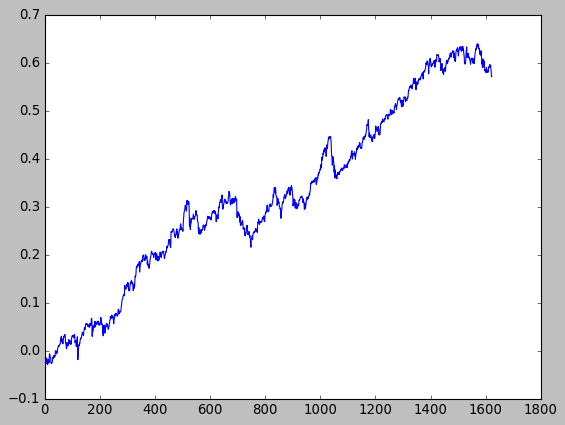

In [92]:
pnl_mv.cumsum().plot()

In [93]:
sharpe_ratio(pnl_mv)
sum_pnl(pnl_mv)
vol_pnl(pnl_mv)

sharpe ratio: 0.9910477238066089
PnL: 8.869443644875439%
Annual volatility: 8.949562601090443%


In [62]:
#Pnl RL
pnl_rl = pd.read_pickle(r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code\notebooks\pnl_vol.pkl")
sharpe_ratio(pnl_rl)
sum_pnl(pnl_rl)
vol_pnl(pnl_rl)

sharpe ratio: 1.1307158363340517
PnL: 9.651714511588086%
Annual volatility: 8.535932903248595%


In [98]:
df_rl2 = pd.read_pickle(r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code\notebooks\results_vol_penalization.pkl")
df_rl1 = pd.read_pickle(r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code\notebooks\results_no_vol_penalization.pkl")

In [115]:
pnl_rl1     = df_rl1.groupby('date_backup')['pnl'].sum()
weights_rl1 = df_rl1.groupby('date_backup')['notional'].sum()
sharpe_ratio(pnl_rl1)
sum_pnl(pnl_rl1)
vol_pnl(pnl_rl1)

sharpe ratio: 0.7720443977125804
PnL: 29.394902381098454%
Annual volatility: 38.07410877948201%


In [116]:
pnl_rl2     = df_rl2.groupby('date_backup')['pnl'].sum()
weights_rl2 = df_rl2.groupby('date_backup')['notional'].sum()
sharpe_ratio(pnl_rl2)
sum_pnl(pnl_rl2)
vol_pnl(pnl_rl2)

sharpe ratio: 0.7444642862750808
PnL: 4.836010634357688%
Annual volatility: 6.4959605497728%


In [101]:
pnl_mv.index = pnl_rl1.index

In [102]:
#pnl mv drl2
#pnl ew top5 drl1
#ex ante vol drl2
#sum notional drl1 vs drl2

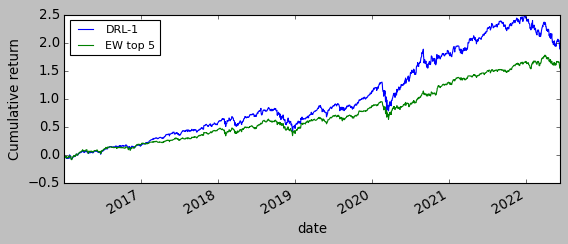

In [112]:
pnl_rl1.cumsum().plot(figsize = (8,3), label = 'DRL-1')
pnl_top_10.cumsum().plot(figsize = (8,3), label = 'EW top 5')
plt.legend(loc = 'best', fontsize = 'small')
plt.xlabel("date")
plt.ylabel("Cumulative return")
plt.savefig("pnl1.jpeg")

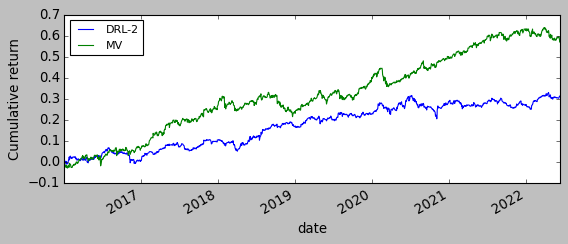

In [113]:
pnl_rl2.cumsum().plot(figsize = (8,3), label = 'DRL-2')
pnl.cumsum().plot(figsize = (8,3), label = 'MV')
plt.legend(loc = 'best', fontsize = 'small')
plt.xlabel("date")
plt.ylabel("Cumulative return")
plt.savefig("pnl2.jpeg")

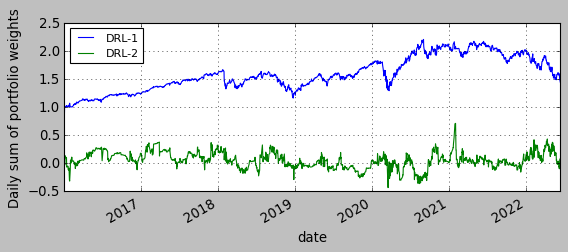

In [114]:
weights_rl1.plot(figsize = (8,3), label = 'DRL-1')
weights_rl2.plot(figsize = (8,3), label = 'DRL-2')
plt.legend(loc = 'best', fontsize = 'small')
plt.grid()
plt.xlabel("date")
plt.ylabel("Daily sum of portfolio weights")
plt.savefig("weights.jpeg")

In [80]:
pnl_rl.corr(pnl)

0.27663578851100246

In [37]:
0.5 * 252**0.5

7.937253933193772

In [16]:
sharpe_ratio(pnl)

sharpe ratio: 0.9910477238066089


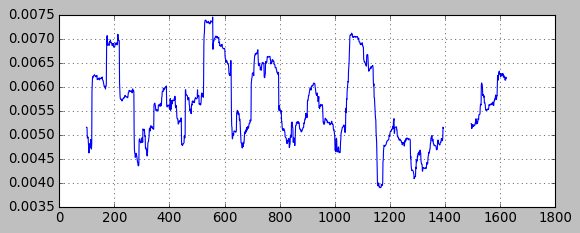

In [18]:
pnl.rolling(100).std().plot(figsize = (8, 3))
plt.grid()